<a href="https://colab.research.google.com/github/johnnysDeu/Thesis/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=jztwpsIzEGc

Building a CNN from scratch with any image dataset

!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
#!pip install "tensorflow<2.11"

In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#!pip install --upgrade pip

In [4]:
#!pip install torchvision

In [5]:

!pip list
import torch

Package                      Version
---------------------------- ------------
absl-py                      1.4.0
appdirs                      1.4.4
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
beautifulsoup4               4.12.2
cachetools                   5.3.0
certifi                      2023.5.7
charset-normalizer           3.1.0
colorama                     0.4.6
comm                         0.1.3
contourpy                    1.1.0
cycler                       0.11.0
debugpy                      1.6.7
decorator                    5.1.1
executing                    1.2.0
filelock                     3.12.2
flatbuffers                  23.5.26
fonttools                    4.40.0
frozendict                   2.3.8
gast                         0.4.0
google-auth                  2.19.0
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.54.2
h5py                         3.8.0


In [6]:
!nvidia-smi

Sun Apr 14 20:29:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
| 49%   43C    P8              17W / 125W |    766MiB /  6144MiB |     14%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [8]:
# add headings with ##(space) on the markdowns

In [9]:
#!pip install tensorflor keras

In [10]:
import tensorflow as tf
import os

In [11]:
!nvidia-smi

Sun Apr 14 20:29:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  | 00000000:2D:00.0  On |                  N/A |
|  0%   43C    P8              17W / 125W |    829MiB /  6144MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9327686915101389295
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4169138176
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3290214819370209777
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [15]:
#! nvidia-smi

In [16]:
#!pip install opencv-python

## Imports

In [17]:
import tensorflow as tf
import os
import cv2
import imghdr

## Removing false images

In [18]:
#from google.colab import drive # fur colab
#drive.mount('/content/drive')

In [19]:
import numpy as np
from matplotlib import pyplot as plt

In [20]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [21]:
#path = '/content/drive/MyDrive/Colab Notebooks/Thesis'
#os.chdir(path)

In [22]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [23]:
data_dir='data'
os.listdir(data_dir)

['Ads', 'Sample_Images']

In [24]:
#os.listdir(os.path.join(data_dir,'Ads'))

In [25]:
imgTest= cv2.imread(os.path.join('data','Sample_Images','converted_main_5.jpg'))
#imgTest= cv2.imread(os.path.join('data','Sample_Images','main_2.jpg'))

In [26]:
type(imgTest)

numpy.ndarray

In [27]:
imgTest.shape

(376, 564, 3)

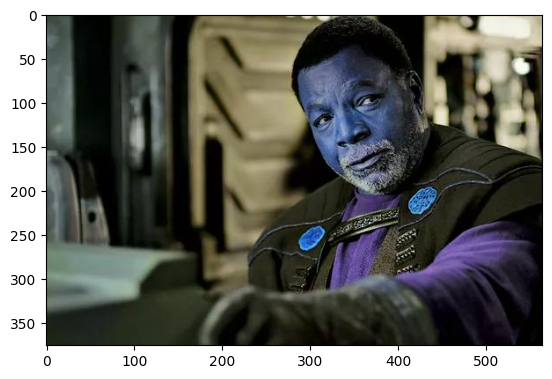

In [28]:
plt.imshow(imgTest)

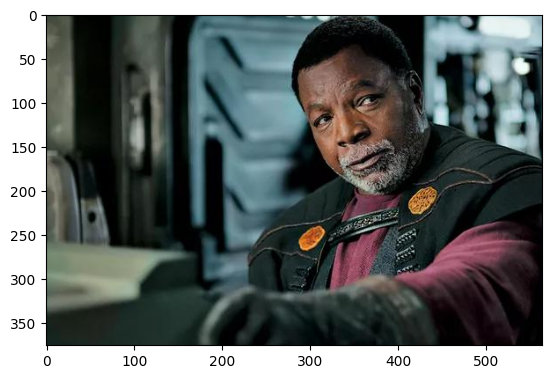

In [29]:
plt.imshow(cv2.cvtColor(imgTest, cv2.COLOR_BGR2RGB))
plt.show()

Load Data

In [30]:
#tf.data.Dataset??

In [31]:
tf.data.Dataset.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None)>

In [32]:
tf.keras.utils.audio_dataset_from_directory??

Signature:
tf.keras.utils.audio_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    batch_size=32,
    sampling_rate=None,
    output_sequence_length=None,
    ragged=False,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False,
)
Source:   
@keras_export("keras.utils.audio_dataset_from_directory", v1=[])
def audio_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    batch_size=32,
    sampling_rate=None,
    output_sequence_length=None,
    ragged=False,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    follow_links=False,
):
    """Generates a `tf.data.Dataset` from audio files in a directory.

    If your directory structure is:

    ```
    main_directory/
    ...class_a/
    ......a_audio_1.wav
    ......a_audio_2.wav
    ...class_b/
    ......b_audio_1.wav
    ......b_audio_2.wav
    ```

  

In [33]:
data=tf.keras.utils.image_dataset_from_directory('data', batch_size=32)

Found 2386 files belonging to 2 classes.


In [34]:
data_iterator=data.as_numpy_iterator()


In [35]:
# get another batch from the iterator
batch=data_iterator.next()


In [36]:
len(batch) # batch contain 2 items, the image batch[0] and the label batch[1]

2

In [37]:
batch[0].shape # images are numpy arrays

(32, 256, 256, 3)

In [38]:
batch[1] # labels

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1])

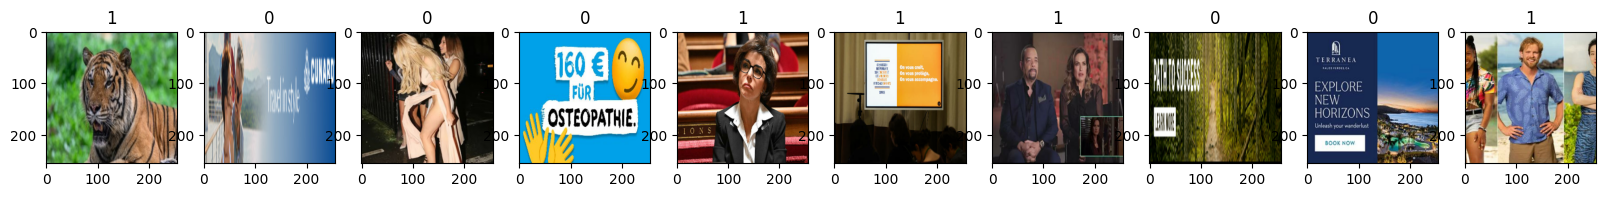

In [39]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20)) # class 1= simple image, class 0 = Ad
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

From the above plot, we see how the function assigns the classes (this may change from run-to-run):

simple image = 1 <br>
Ad = 0

## Preprocess data

In [40]:
print(batch[0].max()) # our pixels are between values 0 and 255. we will scale them to be between 0 and 1

255.0


In [41]:
batch[0]

array([[[[9.34218750e+01, 1.57421875e+02, 1.05703125e+02],
         [9.76875000e+01, 1.61265625e+02, 1.12531250e+02],
         [1.01406250e+02, 1.64406250e+02, 1.20218750e+02],
         ...,
         [1.15812500e+02, 1.92812500e+02, 1.20812500e+02],
         [1.10687500e+02, 1.88265625e+02, 1.14531250e+02],
         [1.07281250e+02, 1.85281250e+02, 1.10281250e+02]],

        [[9.56756897e+01, 1.59675690e+02, 1.08960663e+02],
         [9.89467163e+01, 1.62524841e+02, 1.14283203e+02],
         [1.01990234e+02, 1.64579620e+02, 1.21560089e+02],
         ...,
         [1.18321808e+02, 1.95321808e+02, 1.23321808e+02],
         [1.13607422e+02, 1.91185547e+02, 1.17451172e+02],
         [1.09699310e+02, 1.87699310e+02, 1.12699310e+02]],

        [[9.72381287e+01, 1.60931488e+02, 1.11937653e+02],
         [9.95371094e+01, 1.62937958e+02, 1.16192444e+02],
         [1.02099609e+02, 1.64396484e+02, 1.22391052e+02],
         ...,
         [1.21120331e+02, 1.98120331e+02, 1.26120331e+02],
         [

In [42]:
batch[0]/255

array([[[[3.66360307e-01, 6.17340684e-01, 4.14522052e-01],
         [3.83088231e-01, 6.32414222e-01, 4.41299021e-01],
         [3.97671580e-01, 6.44730389e-01, 4.71446067e-01],
         ...,
         [4.54166681e-01, 7.56127477e-01, 4.73774523e-01],
         [4.34068620e-01, 7.38296568e-01, 4.49142158e-01],
         [4.20710772e-01, 7.26593137e-01, 4.32475477e-01]],

        [[3.75198781e-01, 6.26179159e-01, 4.27296728e-01],
         [3.88026327e-01, 6.37352347e-01, 4.48169410e-01],
         [3.99961710e-01, 6.45410299e-01, 4.76706237e-01],
         ...,
         [4.64007080e-01, 7.65967846e-01, 4.83614922e-01],
         [4.45519298e-01, 7.49747217e-01, 4.60592836e-01],
         [4.30193365e-01, 7.36075699e-01, 4.41958070e-01]],

        [[3.81325990e-01, 6.31103873e-01, 4.38971192e-01],
         [3.90341610e-01, 6.38972402e-01, 4.55656648e-01],
         [4.00390625e-01, 6.44692123e-01, 4.79964912e-01],
         ...,
         [4.74981695e-01, 7.76942492e-01, 4.94589537e-01],
         [

In [43]:
scaled= data.map(lambda x,y: (x/255, y)) # as we load a batch from the pipeline, we scale them on the go

In [44]:
scaled_iterator = data.as_numpy_iterator()

In [45]:
batch = scaled_iterator.next()

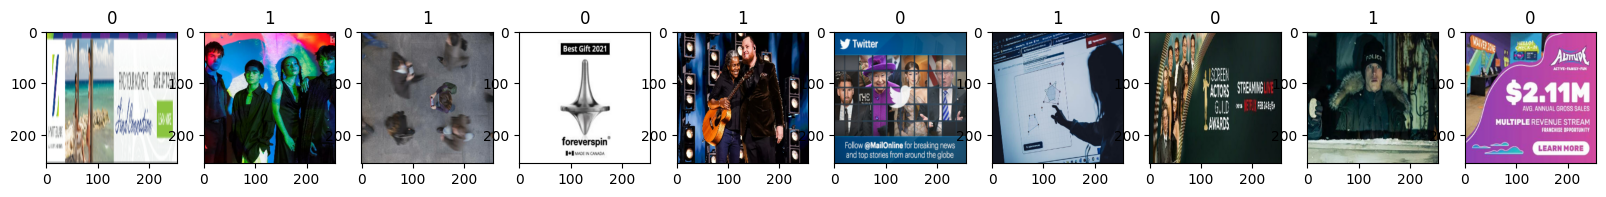

In [46]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20)) # class 1= simple image, class 0 = Ad
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [47]:
batch = scaled.as_numpy_iterator().next()

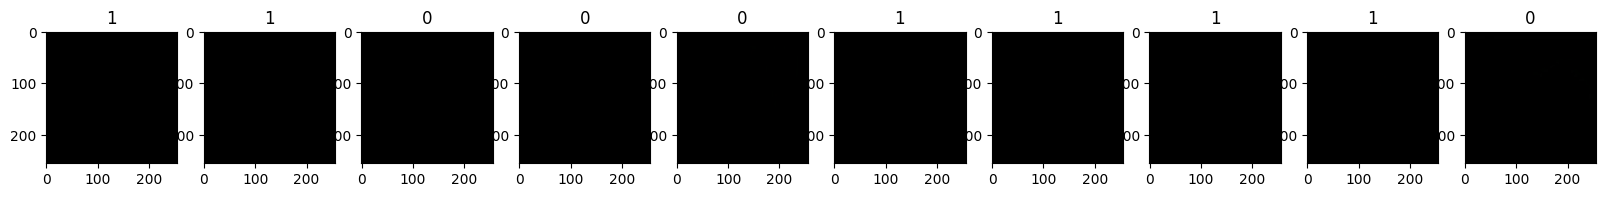

In [48]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20)) # class 1= simple image, class 0 = Ad
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [49]:
#scaled_iterator=scaled.as_numpy_iterator()

In [50]:
#batch = scaled_iterator.next()

In [51]:
#batch[0].min()

In [52]:
#scaled.as_numpy_iterator().next()

# Split Data

In [53]:
#len(scaled)
len(data)

75

In [54]:
train_size = int(len(scaled)*.6)# batch size 8, 156 batches, 32, 41 batches
val_size = int(len(scaled)*.2) # 44 batces
test_size = int(len(scaled)*.2) # 22 batches
#test_size = int(len(scaledtest)) # 22 batches

In [55]:
print(f'Train Size: {train_size}, Val Size:{val_size}, Test Size: {test_size}')


Train Size: 45, Val Size:15, Test Size: 15


In [56]:
train = scaled.take(train_size)
val = scaled.skip(train_size).take(val_size)
test = scaled.skip(train_size+val_size).take(test_size)

In [57]:
train.as_numpy_iterator().next()[0]

array([[[[0.90588236, 0.30980393, 0.29803923],
         [0.90588236, 0.30980393, 0.29803923],
         [0.90588236, 0.30980393, 0.29803923],
         ...,
         [0.9019608 , 0.30588236, 0.29411766],
         [0.9019608 , 0.30664828, 0.28550857],
         [0.9019608 , 0.30980393, 0.28235295]],

        [[0.90588236, 0.30980393, 0.29803923],
         [0.90588236, 0.30980393, 0.29803923],
         [0.90588236, 0.30980393, 0.29803923],
         ...,
         [0.9019608 , 0.30588236, 0.29411766],
         [0.9019608 , 0.30664828, 0.28550857],
         [0.9019608 , 0.30980393, 0.28235295]],

        [[0.90588236, 0.30980393, 0.29803923],
         [0.90588236, 0.30980393, 0.29803923],
         [0.90588236, 0.30980393, 0.29803923],
         ...,
         [0.9019608 , 0.30588236, 0.29411766],
         [0.9019608 , 0.30664828, 0.28550857],
         [0.9019608 , 0.30980393, 0.28235295]],

        ...,

        [[0.84083754, 0.665715  , 0.59322727],
         [0.7977917 , 0.6158155 , 0.5393143 ]

In [58]:
batch[0]

array([[[[7.68627465e-01, 7.68627465e-01, 7.68627465e-01],
         [7.72610307e-01, 7.72610307e-01, 7.72610307e-01],
         [7.77879894e-01, 7.77879894e-01, 7.77879894e-01],
         ...,
         [4.89093125e-01, 4.73406851e-01, 4.77328420e-01],
         [4.78492647e-01, 4.62806374e-01, 4.66727942e-01],
         [4.87561285e-01, 4.71875012e-01, 4.75796580e-01]],

        [[7.68627465e-01, 7.68627465e-01, 7.68627465e-01],
         [7.72610307e-01, 7.72610307e-01, 7.72610307e-01],
         [7.77879894e-01, 7.77879894e-01, 7.77879894e-01],
         ...,
         [4.91212845e-01, 4.75526571e-01, 4.79448140e-01],
         [4.81749773e-01, 4.66063499e-01, 4.69985068e-01],
         [4.90870088e-01, 4.75183815e-01, 4.79105383e-01]],

        [[7.68627465e-01, 7.68627465e-01, 7.68627465e-01],
         [7.72610307e-01, 7.72610307e-01, 7.72610307e-01],
         [7.77879894e-01, 7.77879894e-01, 7.77879894e-01],
         ...,
         [4.91605401e-01, 4.75919127e-01, 4.79840696e-01],
         [

In [59]:
len(train)

45

# Model

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten ,Dropout

In [61]:
model = Sequential()

In [62]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) # mhpws 150,150
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

#model.add(Conv2D(128, (3,3), 1, activation='relu'))
#model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [63]:
from keras import optimizers
#model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4), loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Train

In [65]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20


37/45 [=======================>......] - ETA: 0s - loss: 0.6521 - accuracy: 0.6368

ResourceExhaustedError: Graph execution error:

Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\YannisPC\AppData\Local\Temp\ipykernel_17924\3485218523.py", line 1, in <module>
      hist = model.fit(train, epochs=20, validation_data=val)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
Detected at node 'IteratorGetNext' defined at (most recent call last):
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.9_3.9.3568.0_x64__qbz5n2kfra8p0\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\YannisPC\AppData\Local\Temp\ipykernel_17924\3485218523.py", line 1, in <module>
      hist = model.fit(train, epochs=20, validation_data=val)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\YannisPC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\engine\training.py", line 1145, in step_function
      data = next(iterator)
Node: 'IteratorGetNext'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  Failed to allocate memory for the batch of component 0
	 [[{{node IteratorGetNext}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[IteratorGetNext/_2]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  Failed to allocate memory for the batch of component 0
	 [[{{node IteratorGetNext}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1081]

In [ ]:
model.save('Ad_classifier_medium_1.h5')

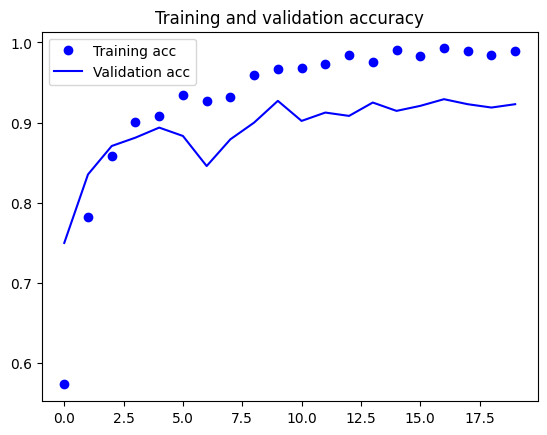

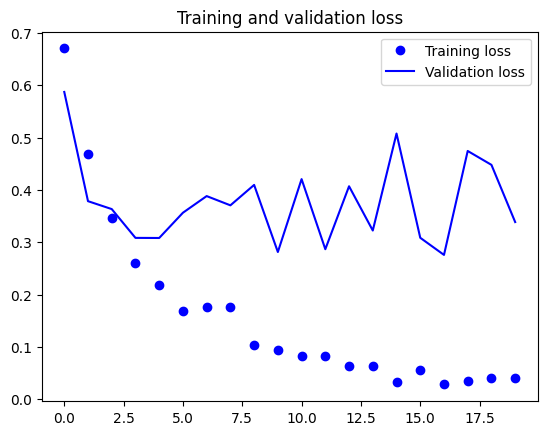

In [ ]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluate

In [ ]:

from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
#test_loss, test_acc = model.evaluate(processed_test_X, processed_test_y)
#print('Accuracy in the testing data:', test_acc)

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    print(f'Precision: {pre.result()}, Recall:{re.result()}, Accuracy: {acc.result()}')
    test_loss, test_acc = model.evaluate(X, y)
    #print('Accuracy in the testing data:', test_acc)
    #print('Loss in the testing data:', test_loss)

1/1 [==============================] - 0s 43ms/step
Precision: 0.8699029088020325, Recall:0.9352818131446838, Accuracy: 0.8983402252197266
1/1 [==============================] - 0s 28ms/step
Precision: 0.8667917251586914, Recall:0.9371196627616882, Accuracy: 0.8975903391838074
1/1 [==============================] - 0s 29ms/step
Precision: 0.8667883276939392, Recall:0.9387351870536804, Accuracy: 0.8988326787948608
1/1 [==============================] - 0s 29ms/step
Precision: 0.8652482032775879, Recall:0.9366602897644043, Accuracy: 0.897169828414917
1/1 [==============================] - 0s 30ms/step
Precision: 0.8681507110595703, Recall:0.9354243278503418, Accuracy: 0.8974359035491943
1/1 [==============================] - 0s 27ms/step
Precision: 0.8671096563339233, Recall:0.9371633529663086, Accuracy: 0.8976868391036987
1/1 [==============================] - 0s 27ms/step
Precision: 0.8663446307182312, Recall:0.9372822046279907, Accuracy: 0.8970588445663452
1/1 [=======================

# Extra Testing on Unseen Data

In [ ]:
import cv2

In [ ]:
Current_dir = os.getcwd()
Current_dir

'c:\\Users\\YannisPC\\PycharmProjects\\Thesis\\Thesis'

In [ ]:
#img = cv2.imread('sim.jpg')
#img= cv2.imread(os.path.join('testData','4.png')) # s (246).jpg, 9.png, 4.png, s (481).jpg
img= cv2.imread(os.path.join('unseen data','main_12.jpg')) # futurama.jpeg, homer-simpson-wallpaper-preview.jpg , zoid.jpeg, bart-simpson-.jpg, fry.jpeg, homer-simpson-the-simpsons-.jpg, marg.jpg
#img

In [ ]:
len(img)


384

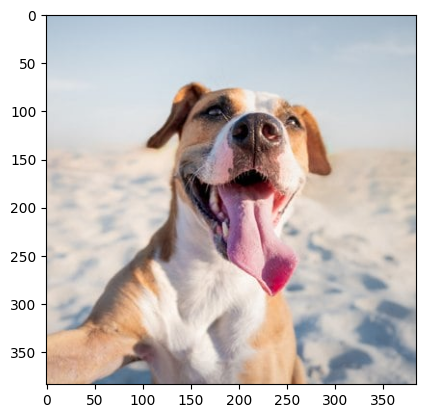

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

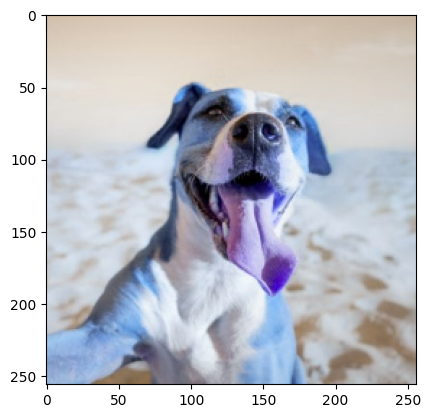

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
resize.shape

TensorShape([256, 256, 3])

In [ ]:
np.expand_dims(resize,0).shape

(1, 256, 256, 3)

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 84ms/step


array([[0.98988485]], dtype=float32)

In [ ]:
#class 1= Ad, class 0 = simple

if yhat < 0.5:
    print(f'Predicted Simple Image')
else:
    print(f'Predicted Ad')

Predicted Ad


# Saving the model

In [ ]:
from keras.models import load_model

In [ ]:
model.save(os.path.join('models','model_based_on_futurama.h5'))
#model.summary()

NameError: name 'model' is not defined

In [ ]:
new_model = load_model(os.path.join('models','model_based_on_futurama.h5'))
new_model

NameError: name 'load_model' is not defined

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 61ms/step


array([[0.9722497]], dtype=float32)